In [69]:
import pandas as pd
import numpy as np
import scipy.stats 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import chi2

In [70]:
train_clean=pd.read_csv('data/train_clean.csv')
test_clean=pd.read_csv('data/test_clean.csv')

In [71]:
train_clean=pd.get_dummies(train_clean)

In [72]:
y= train_clean.pop('Survived')
X = train_clean

In [73]:
selector = SelectKBest(chi2, k=5)
selector.fit(X, y)

SelectKBest(k=5, score_func=<function chi2 at 0x0000021161AAE3A8>)

In [74]:
X_new = selector.transform(X)
X_new.shape

(891, 5)

In [75]:
X.columns[selector.get_support(indices=True)].tolist()

['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male']

## les variables les plus pertinentes sont 'tarif ' et 'femme'

In [76]:
Xtrain, Xtest , ytrain, ytest = train_test_split(X_new,y , train_size=0.8)
reg_log = LogisticRegression(solver = 'lbfgs')
reg_log.fit(Xtrain, ytrain)
y_pred = reg_log.predict(Xtest)

In [77]:
from sklearn.metrics import classification_report
print(classification_report(ytest, y_pred))

from sklearn.metrics import accuracy_score
print(accuracy_score(ytest, y_pred)) # le plus important pour le moment; précisément la première ligne

from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.88      0.81        94
           1       0.84      0.66      0.74        85

    accuracy                           0.78       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.78      0.77       179

0.776536312849162
[[83 11]
 [29 56]]


In [78]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
proba = reg_log.predict_proba(X_new)
fpr0, tpr0, thresholds0 = roc_curve(y, proba[:, 0], pos_label=reg_log.classes_[0], drop_intermediate=False)
thresholds0.shape

(746,)

In [79]:
tp = pd.DataFrame(dict(fpr=fpr0, tpr=tpr0, threshold=thresholds0))
#tp.head()
tp.drop(0, axis=0, inplace=True) #suppression du 1er seuil fixé arbitrairement à 2

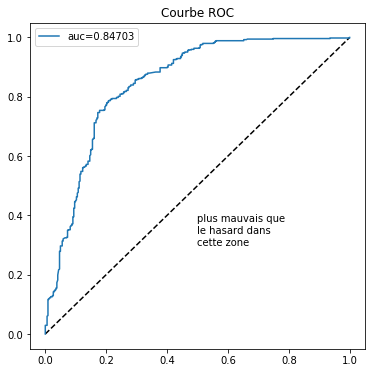

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr0, tpr0)
ax.plot(fpr0, tpr0, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC')
ax.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
ax.legend();

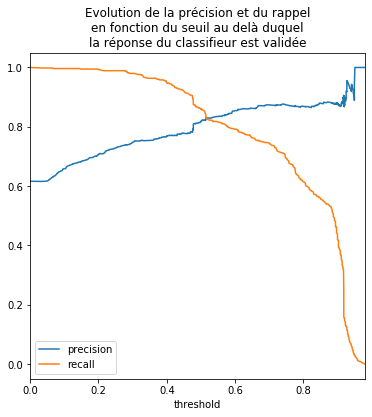

In [81]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y, proba[:, 0], pos_label=reg_log.classes_[0])

pr = pd.DataFrame(dict(precision=precision, recall=recall, 
                             threshold=[0] + list(thresholds)))

ax = pr.plot(x="threshold", y=['precision', 'recall'], figsize=(6,6))
ax.set_title("Evolution de la précision et du rappel\nen fonction du seuil au delà duquel\n" + 
             "la réponse du classifieur est validée");

In [85]:
coef = pd.DataFrame(np.concatenate([reg_log.intercept_.reshape(-1,1), reg_log.coef_],axis=1),
             index = ["Coefficients"],
             columns = ["constante"]+list(X.columns[selector.get_support(indices=True)].tolist())).T

# Calcul de l'exponentiel pour avoir les odds-ratio
coef["OR"] = np.exp(coef.Coefficients)
coef


,Coefficients,OR
constante,3.235990,25.431539
Pclass,-1.171778,0.309816
Age,-0.031696,0.968801
Fare,0.000618,1.000618
Sex_female,1.251553,3.495768
Sex_male,-1.251585,0.286051
